<a href="https://colab.research.google.com/github/10points/gauge-reader/blob/main/2classes_Gauge_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extract train data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/gauge_work/train_80_2classes.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# Extract test data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/gauge_work/test_20_2classes.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
# Check number of files in train set
for dirpath, dirnames, filenames, in os.walk("/content/content/train"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

there are 2 directories and 0 images in /content/content/train
there are 0 directories and 208 images in /content/content/train/chiller_gauge
there are 0 directories and 217 images in /content/content/train/not_chiller_gauge


In [6]:
# Check number of files in test set
for dirpath, dirnames, filenames, in os.walk("/content/content/test"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

there are 2 directories and 0 images in /content/content/test
there are 0 directories and 52 images in /content/content/test/chiller_gauge
there are 0 directories and 55 images in /content/content/test/not_chiller_gauge


In [7]:
# Get class name
data_dir = pathlib.Path("/content/content/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chiller_gauge' 'not_chiller_gauge']


In [8]:
# Show random image function
def show_random_image(target_dir, target_class):
  target_folder = f"{target_dir}/{target_class}"

  random_img = random.sample(os.listdir(target_folder), 1)
  print(random_img)

  # plotting
  img = mpimg.imread(target_folder + "/" + random_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

['PXL_20220615_072410592.jpg']
Image shape: (4032, 3024, 3)
['IMG_4232.jpg']
Image shape: (4032, 3024, 3)


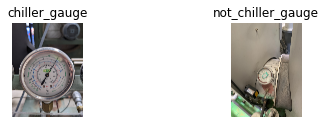

In [9]:
figsize=(15,10)
plt.figure(figsize=figsize)
for index, name in enumerate(class_names):
  # print(index, name)
  plt.subplot(5,4,index+1)
  show_random_image(target_dir="/content/content/train",
                    target_class=name)

## Preprocessing

In [10]:
# Create data generator and re scale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = "/content/content/train"
test_dir = "/content/content/test"

# Load image data from directories into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               batch_size=32,
                                               shuffle=False)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224,224),
                                             class_mode="binary",
                                             batch_size=32,
                                             shuffle=False)

Found 425 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


In [11]:
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [12]:
images_test, labels_test = test_data.next()
len(images_test), len(labels_test)

(32, 32)

In [13]:
# numbers of batches
len(train_data)

14

In [14]:
images[:2], images[0].shape

(array([[[[0.72156864, 0.7254902 , 0.7019608 ],
          [0.72156864, 0.7254902 , 0.7019608 ],
          [0.7568628 , 0.7568628 , 0.7490196 ],
          ...,
          [0.2509804 , 0.24705884, 0.26666668],
          [0.25882354, 0.25490198, 0.27450982],
          [0.24705884, 0.24313727, 0.26666668]],
 
         [[0.70980394, 0.7137255 , 0.6901961 ],
          [0.7294118 , 0.73333335, 0.7137255 ],
          [0.7176471 , 0.72156864, 0.7019608 ],
          ...,
          [0.227451  , 0.21960786, 0.2392157 ],
          [0.21568629, 0.20784315, 0.227451  ],
          [0.21568629, 0.20784315, 0.227451  ]],
 
         [[0.7254902 , 0.73333335, 0.7137255 ],
          [0.7254902 , 0.7294118 , 0.70980394],
          [0.7137255 , 0.7176471 , 0.69803923],
          ...,
          [0.25882354, 0.2509804 , 0.27058825],
          [0.22352943, 0.21960786, 0.2392157 ],
          [0.21176472, 0.20392159, 0.20784315]],
 
         ...,
 
         [[0.8196079 , 0.8117648 , 0.76470596],
          [0.81176

In [15]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [16]:
labels_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [17]:
len(test_data)

4

##Modeling

1.Baseline

In [18]:
# Create the baseline model
model_1 = Sequential()
model_1.add(Conv2D(10, (3,3), input_shape=(224,224,3)))
model_1.add(Activation("relu"))
model_1.add(MaxPool2D(pool_size=(2,2)))
model_1.add(Flatten())
model_1.add(Dense(1))
model_1.add(Activation("sigmoid"))

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [19]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
14/14 [==============================] - 100s 6s/step - loss: 1.7826 - accuracy: 0.6047 - val_loss: 0.8696 - val_accuracy: 0.4860
Epoch 2/10
14/14 [==============================] - 82s 6s/step - loss: 0.6144 - accuracy: 0.6988 - val_loss: 0.6694 - val_accuracy: 0.5140
Epoch 3/10
14/14 [==============================] - 82s 6s/step - loss: 0.6625 - accuracy: 0.5812 - val_loss: 0.5550 - val_accuracy: 0.6542
Epoch 4/10
14/14 [==============================] - 83s 6s/step - loss: 0.4158 - accuracy: 0.8118 - val_loss: 0.4172 - val_accuracy: 0.8598
Epoch 5/10
14/14 [==============================] - 82s 6s/step - loss: 0.2485 - accuracy: 0.9482 - val_loss: 0.2987 - val_accuracy: 0.8785
Epoch 6/10
14/14 [==============================] - 86s 6s/step - loss: 0.1714 - accuracy: 0.9435 - val_loss: 0.4579 - val_accuracy: 0.7850
Epoch 7/10
14/14 [==============================] - 83s 6s/step - loss: 0.1268 - accuracy: 0.9788 - val_loss: 0.2854 - val_accuracy: 0.8692
Epoch 8/10
14/14 [=

In [20]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 activation (Activation)     (None, 222, 222, 10)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 10)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 123210)            0         
                                                                 
 dense (Dense)               (None, 1)                 123211    
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                        

In [26]:
# Plot the validation and training curve separately
def plot_loss_curve(history):
  """
  Returns separate loss curve for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) 

  # Plot loss 
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

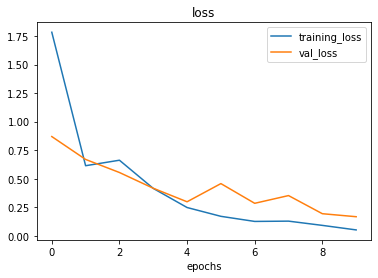

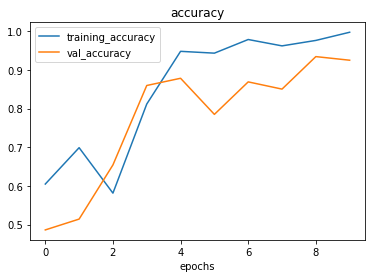

In [27]:
plot_loss_curve(history_1)

### Data augmentation

In [35]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, 
                                             shear_range=0.2, 
                                             zoom_range=0.2, 
                                             width_shift_range=0.2, 
                                             height_shift_range=0.2, 
                                             horizontal_flip=True) 

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [36]:
train_dir = "/content/content/train"
test_dir = "/content/content/test"

print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='binary',
                                                         shuffle=True) 

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary',
                                             shuffle=False)

Augmented training images:
Found 425 images belonging to 2 classes.
Unchanged test images:
Found 107 images belonging to 2 classes.


In [37]:
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [38]:
# Create the model
model_2 = Sequential([
  Conv2D(10, (3, 3), input_shape=(224, 224, 3)),
  Activation("relu"),
  MaxPool2D(pool_size=(2, 2)),
  Conv2D(10, (3, 3)),
  Activation("relu"),
  MaxPool2D(pool_size=(2, 2)),
  Conv2D(10, (3, 3)),
  Activation("relu"),
  MaxPool2D(),
  Flatten(),
  Dense(1),
  Activation("sigmoid")
])

# Compile model_2
model_2.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])
# Fit the model
history_2 = model_2.fit(train_data_augmented,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
14/14 [==============================] - 91s 7s/step - loss: 0.6958 - accuracy: 0.5600 - val_loss: 0.6743 - val_accuracy: 0.5234
Epoch 2/10
14/14 [==============================] - 86s 6s/step - loss: 0.6762 - accuracy: 0.5176 - val_loss: 0.6361 - val_accuracy: 0.5514
Epoch 3/10
14/14 [==============================] - 88s 6s/step - loss: 0.6529 - accuracy: 0.6165 - val_loss: 0.5193 - val_accuracy: 0.8692
Epoch 4/10
14/14 [==============================] - 86s 6s/step - loss: 0.6048 - accuracy: 0.6918 - val_loss: 0.4554 - val_accuracy: 0.7196
Epoch 5/10
14/14 [==============================] - 85s 6s/step - loss: 0.5452 - accuracy: 0.7647 - val_loss: 0.3676 - val_accuracy: 0.7850
Epoch 6/10
14/14 [==============================] - 87s 6s/step - loss: 0.5207 - accuracy: 0.7412 - val_loss: 0.3619 - val_accuracy: 0.9065
Epoch 7/10
14/14 [==============================] - 86s 6s/step - loss: 0.5104 - accuracy: 0.7624 - val_loss: 0.3396 - val_accuracy: 0.9159
Epoch 8/10
14/14 [==

In [39]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 activation_2 (Activation)   (None, 222, 222, 10)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 activation_3 (Activation)   (None, 109, 109, 10)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                  

In [44]:
from keras.callbacks import EarlyStopping

In [47]:
# Create the model
model_3 = tf.keras.models.clone_model(model_2) 


earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# Compile model_2
model_3.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])
# Fit the model
history_3 = model_3.fit(train_data_augmented,
                        epochs=20,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[earlystop])

Epoch 1/20
14/14 [==============================] - 93s 7s/step - loss: 0.6755 - accuracy: 0.5835 - val_loss: 0.6090 - val_accuracy: 0.8318
Epoch 2/20
14/14 [==============================] - 85s 6s/step - loss: 0.6127 - accuracy: 0.6847 - val_loss: 0.5325 - val_accuracy: 0.7757
Epoch 3/20
14/14 [==============================] - 85s 6s/step - loss: 0.5811 - accuracy: 0.7012 - val_loss: 0.4911 - val_accuracy: 0.7944
Epoch 4/20
14/14 [==============================] - 86s 6s/step - loss: 0.5588 - accuracy: 0.7365 - val_loss: 0.4496 - val_accuracy: 0.8598
Epoch 5/20
14/14 [==============================] - 85s 6s/step - loss: 0.5043 - accuracy: 0.7694 - val_loss: 0.4900 - val_accuracy: 0.7103
Epoch 6/20
14/14 [==============================] - 85s 6s/step - loss: 0.5018 - accuracy: 0.7788 - val_loss: 0.4201 - val_accuracy: 0.8411
Epoch 7/20
14/14 [==============================] - 86s 6s/step - loss: 0.5051 - accuracy: 0.7624 - val_loss: 0.3391 - val_accuracy: 0.8879
Epoch 8/20
14/14 [==

In [48]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 activation_2 (Activation)   (None, 222, 222, 10)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 activation_3 (Activation)   (None, 109, 109, 10)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                  

## Model evaluation

In [28]:
def summary_model(model):
  # get prediction probabilities
  test_steps_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)
  predictions = model.predict_generator(test_data, steps=test_steps_per_epoch)

  # make y prediction
  y_preds = []
  for i in range(len(predictions)):
    if class_names[int(tf.round(predictions[i][0]))] == 'chiller_gauge':
      y_preds.append(0)
    else:
      y_preds.append(1)

  # visualize confusion matrix
    # Get ground-truth classes and class-labels
  true_classes = test_data.classes
  class_labels = list(test_data.class_indices.keys())
  print("0: 'Chiller gauge', 1: 'Not chiller gauge'")
  

  # Concusion matrix
  print("confusion matrix")
  # print(confusion_matrix(true_classes, predicted_classes))
  cm = confusion_matrix(true_classes, y_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

  # Use scikit-learn to get statistics
  report = metrics.classification_report(true_classes, y_preds, target_names=class_labels)
  print(report)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


0: 'Chiller gauge', 1: 'Not chiller gauge'
confusion matrix


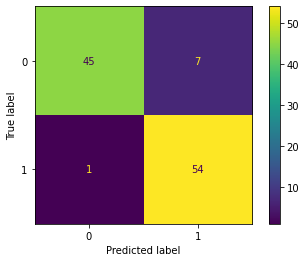

                   precision    recall  f1-score   support

    chiller_gauge       0.98      0.87      0.92        52
not_chiller_gauge       0.89      0.98      0.93        55

         accuracy                           0.93       107
        macro avg       0.93      0.92      0.92       107
     weighted avg       0.93      0.93      0.92       107



In [29]:
summary_model(model_1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


0: 'Chiller gauge', 1: 'Not chiller gauge'
confusion matrix


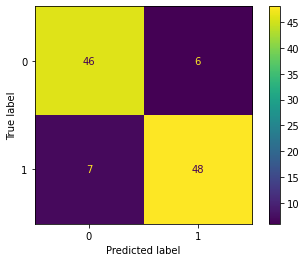

                   precision    recall  f1-score   support

    chiller_gauge       0.87      0.88      0.88        52
not_chiller_gauge       0.89      0.87      0.88        55

         accuracy                           0.88       107
        macro avg       0.88      0.88      0.88       107
     weighted avg       0.88      0.88      0.88       107



In [41]:
summary_model(model_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


0: 'Chiller gauge', 1: 'Not chiller gauge'
confusion matrix


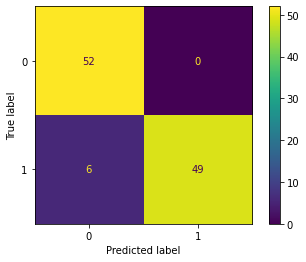

                   precision    recall  f1-score   support

    chiller_gauge       0.90      1.00      0.95        52
not_chiller_gauge       1.00      0.89      0.94        55

         accuracy                           0.94       107
        macro avg       0.95      0.95      0.94       107
     weighted avg       0.95      0.94      0.94       107



In [50]:
summary_model(model_3)

## Save model

In [51]:
os.mkdir("save_model")

In [ ]:
# model_1.save_weights("/content/save_model/model_1.hdf5")

In [52]:
model_3.save_weights("/content/save_model/model_3_2classes.h5")

In [53]:
model_3.save("/content/save_model/model_3_2classes.h5")

In [54]:
model_1.save("/content/save_model/model_1_2classes.h5")

In [55]:
predicted_model = tf.keras.models.load_model("/content/save_model/model_3_2classes.h5")

In [56]:
predicted_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 activation_2 (Activation)   (None, 222, 222, 10)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 activation_3 (Activation)   (None, 109, 109, 10)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                  

In [59]:
def load_and_prep_image(filename, img_shape=224):

  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [60]:
def plot_random_image(model, images_path, true_labels, classes):
  '''True labels(str): Manually label image which you picked from any classes'''

  # Load image
  images = load_and_prep_image(images_path)
  
  
  pred_probs = model.predict(tf.expand_dims(images, axis=0)) 
  pred_label = classes[pred_probs.argmax()]
  true_label = true_labels

  # Plot the target image
  plt.imshow(images)

  # Change the color of the titles depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Add xlabel information (prediction/true label)
  plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                   100*tf.reduce_max(pred_probs),
                                                   true_label),
             color=color) # set the color to green or red

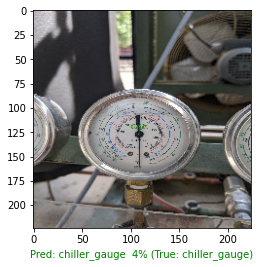

In [61]:
plot_random_image(model=predicted_model, 
                  images_path="/content/content/test/chiller_gauge/PXL_20220615_030411874.jpg",
                  true_labels="chiller_gauge",
                  classes=class_names)

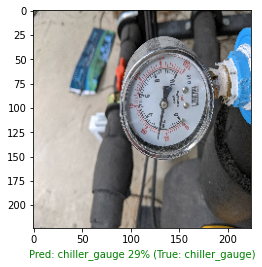

In [62]:
plot_random_image(model=predicted_model, 
                  images_path="/content/content/test/chiller_gauge/PXL_20220601_030351319.jpg",
                  true_labels="chiller_gauge",
                  classes=class_names)